In [88]:
import sklearn 
import tensorflow as tf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn

In [90]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
     "Train",
     image_size=(256, 256),
     shuffle = True,
     batch_size=32
     )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
     "Val",
     image_size=(256, 256),
     shuffle = True,
     batch_size=32
     )
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
     "Test",
     image_size=(256, 256),
     shuffle = True,
     batch_size=32
     )

Found 11108 files belonging to 6 classes.
Found 2495 files belonging to 6 classes.
Found 280 files belonging to 6 classes.


In [91]:
class_names=train_ds.class_names
class_names

['Bacterial Spot',
 'Early Blight',
 'Healthy',
 'Late Blight',
 'Septoria Leaf Spot',
 'Yellow Leaf Curl Virus']

Text(0.5, 1.0, 'Early Blight')

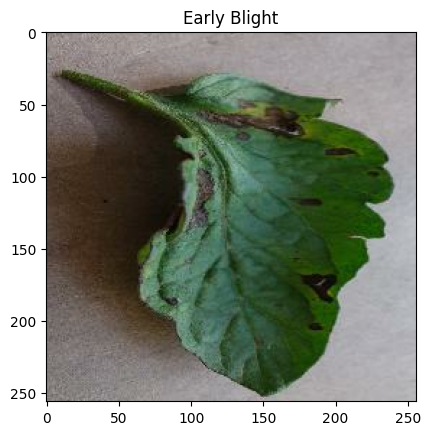

In [92]:
iterator = train_ds.as_numpy_iterator()
# Get the first batch of images and labels
batch = next(iterator)

# Assuming the first element of the batch is the image
image = batch[0][0]
label = batch[1][0] # Get the label for the first image

plt.imshow(image.astype("uint8")) # Corrected the type to "uint8"
plt.title(class_names[label]) # Access class names from train_ds and use label index

In [61]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


In [62]:
from tensorflow.keras import models, layers
reshape_resize = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0/255)
])

In [63]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),           # Randomly flip images horizontally
    layers.RandomRotation(0.1),                # Randomly rotate images by 10%
    layers.RandomZoom(0.1),                    # Randomly zoom images
    layers.RandomContrast(0.1),                # Adjust contrast slightly
   layers.RandomTranslation(0.1, 0.1),        # Random shift in width and height
    ])



Load MobileNetV2 with pretrained weights (transfer learning)

In [66]:
base_model = tf.keras.applications.MobileNetV2(
      input_shape=(256, 256, 3),
      include_top=False,  # Remove final dense layers of MobileNetV2
      weights='imagenet'  # Load pretrained weights
      )
base_model.trainable = False  # Freeze the base model layers


C:\Users\LC\AppData\Local\Temp\ipykernel_4348\1966742154.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [68]:
                                            # Build the complete model
model = models.Sequential([
    data_augmentation,
    reshape_resize,
    base_model,
    layers.GlobalAveragePooling2D(),         # Flattening
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Output lay
    ])


In [74]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [76]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("models/tomato_disease_model.keras", save_best_only=True)
]


In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    callbacks=callbacks)


 Fine-tune all layers (trainable base + head)

In [114]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR!
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10,
          callbacks=callbacks)  # reuse EarlyStopping + ModelCheckpoint


Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1982s 6s/step - accuracy: 0.6935 - loss: 1.4408 - val_accuracy: 0.8910 - val_loss: 0.3246
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1873s 5s/step - accuracy: 0.8807 - loss: 0.3676 - val_accuracy: 0.8032 - val_loss: 0.7414
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1309s 4s/step - accuracy: 0.9157 - loss: 0.2576 - val_accuracy: 0.7587 - val_loss: 0.9444
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1455s 4s/step - accuracy: 0.9263 - loss: 0.2088 - val_accuracy: 0.7339 - val_loss: 1.0868
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1955s 6s/step - accuracy: 0.9383 - loss: 0.1710 - val_accuracy: 0.7507 - val_loss: 0.9963
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 1933s 6s/step - accuracy: 0.9529 - loss: 0.1386 - val_accuracy: 0.7723 - val_loss: 0.8612


In [116]:
model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 601ms/step - accuracy: 0.9018 - loss: 0.3153


[0.3346847891807556, 0.8964285850524902]

In [118]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 348}

In [120]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss =  history.history['loss']
val_loss =  history.history['val_loss']

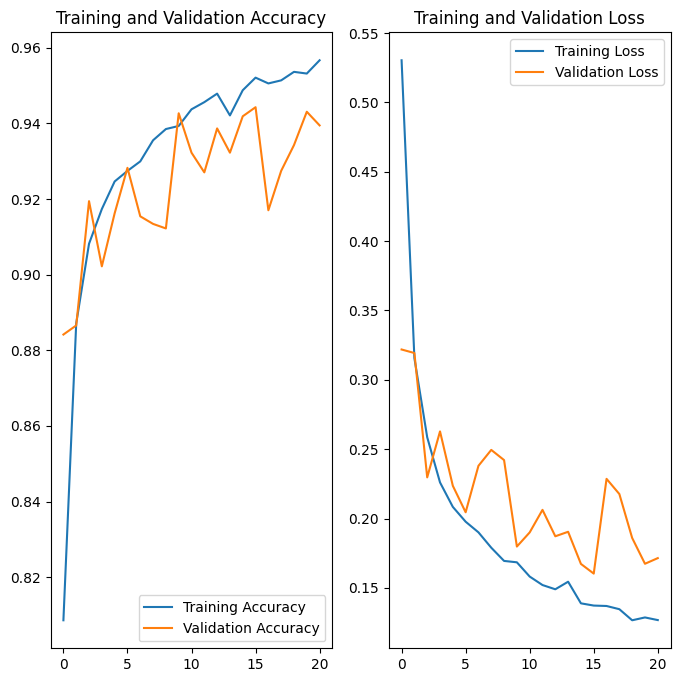

In [122]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(21), accuracy, label='Training Accuracy')
plt.plot(range(21), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(21), loss, label='Training Loss')
plt.plot(range(21), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Late Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
predicted label: Late Blight


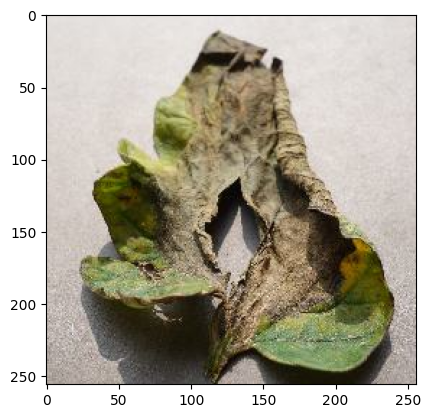

In [126]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [128]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


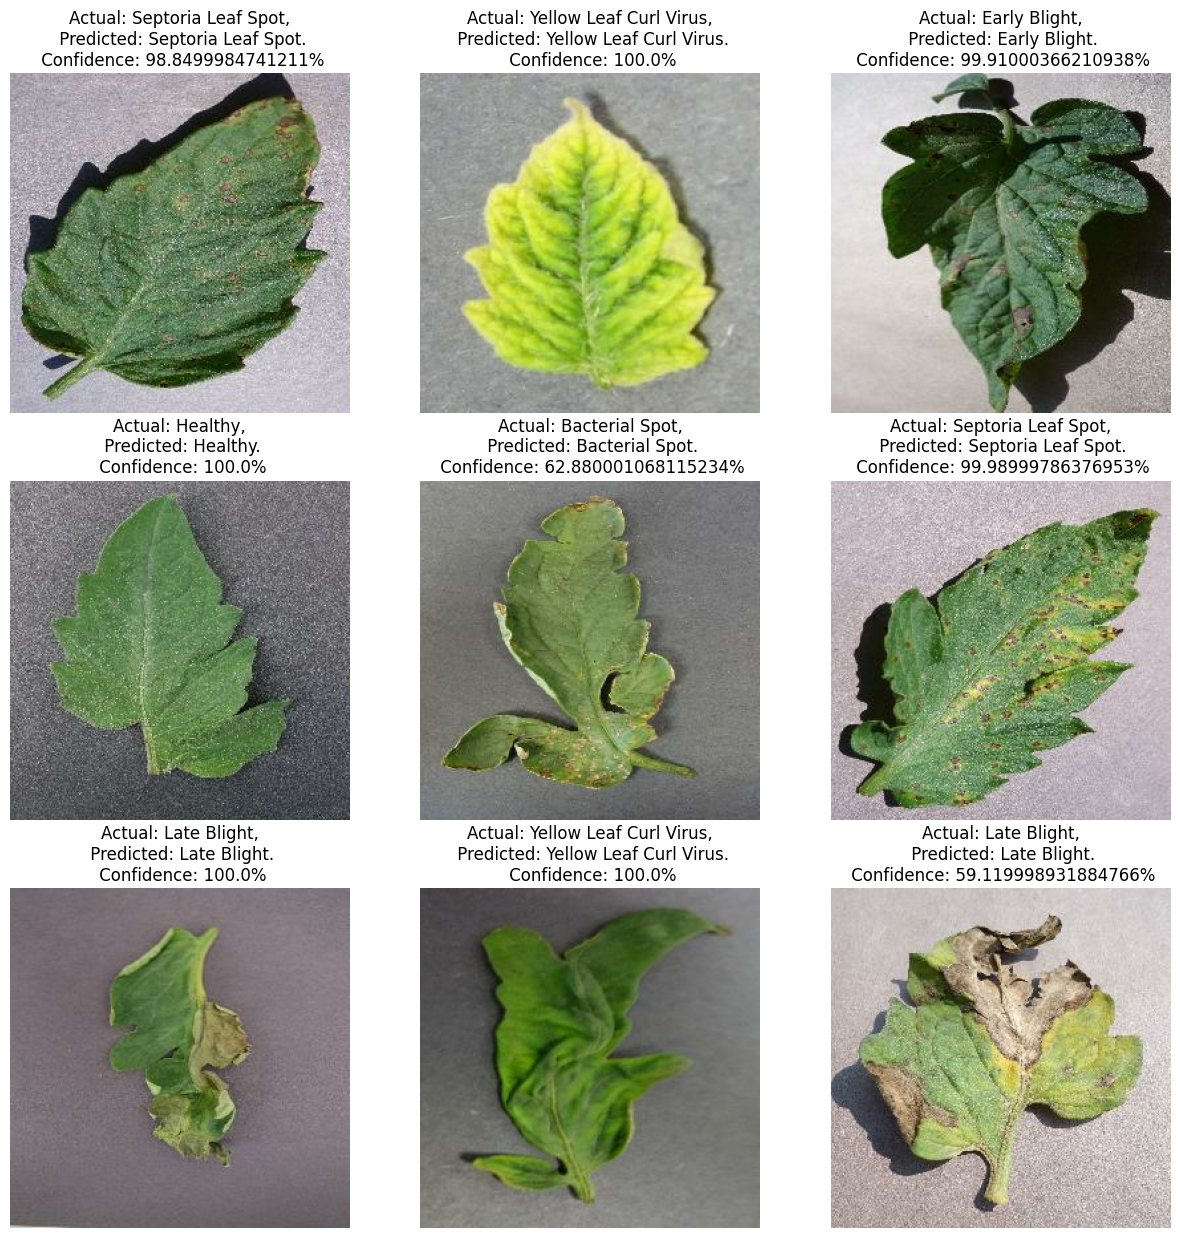

In [170]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
plt.savefig("../images/sample_predictions2.png")

In [168]:
model_version=2
model.save(f'../models/tomato_disease_model{model_version}.keras')